In [31]:
from datasets import load_dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from PIL import Image, ImageEnhance
import random
import torch

In [5]:
dataset = load_dataset("garythung/trashnet")
dataset

<Figure size 640x480 with 0 Axes>

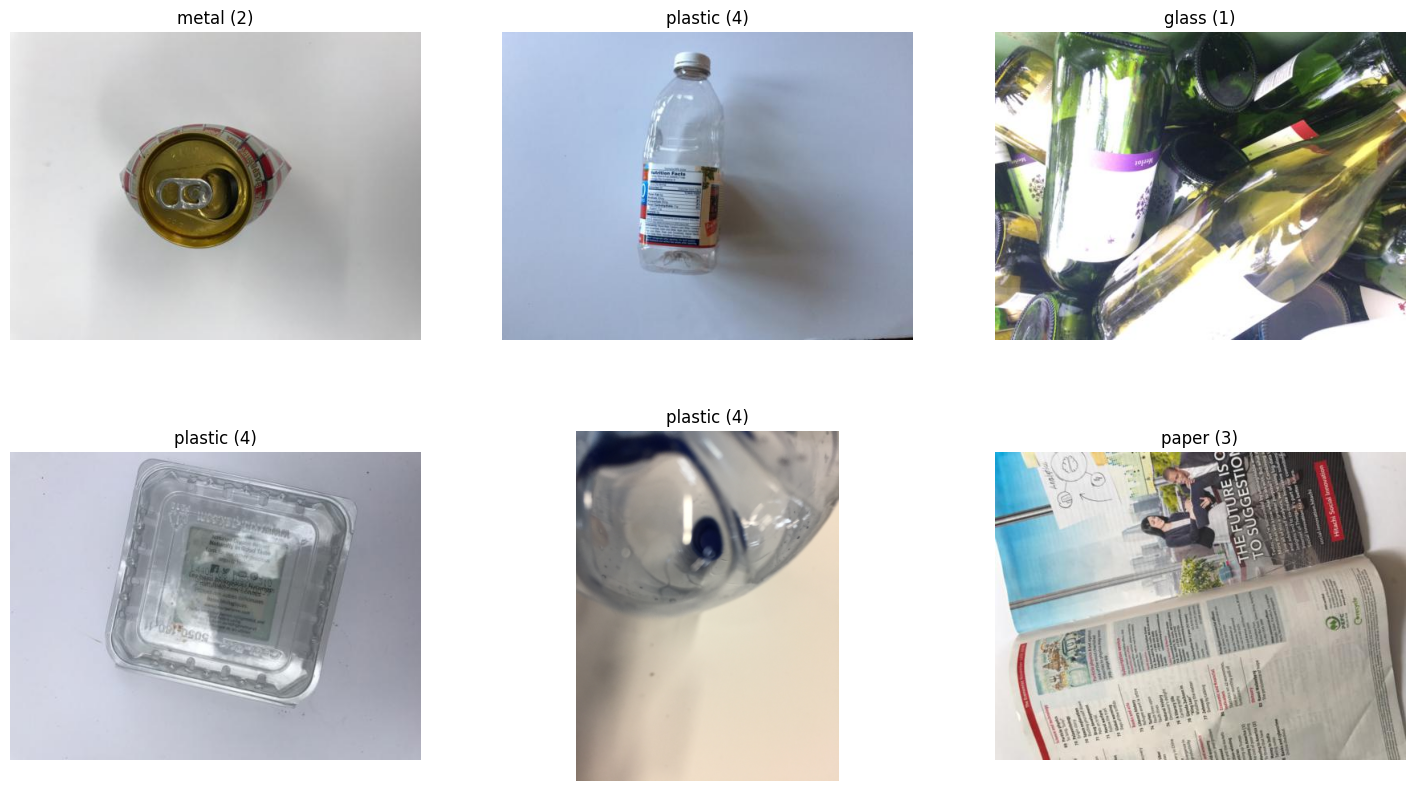

In [6]:
labels = {
    0: "cardboard",
    1: "glass",
    2: "metal",
    3: "paper",
    4: "plastic",
    5: "trash"
}

def display_random(dataset, num_images=4):
    rows = 2
    cols = np.ceil(num_images / rows).astype(int)

    plt.figure(figsize=(18, 10))
    indices = np.random.choice(range(len(dataset)), size=num_images, replace=False)

    for i, idx in enumerate(indices, 1):
        idx = int(idx)
        image = dataset[idx]['image']
        label = dataset[idx]['label']
        label_name = labels.get(label, "Unknown")

        plt.subplot(rows, cols, i)
        plt.imshow(image)
        plt.title(f"{label_name} ({label})")
        plt.axis('off')

plt.tight_layout()
plt.show()

display_random(dataset['train'], num_images=6)

Map:   0%|          | 0/5054 [00:00<?, ? examples/s]

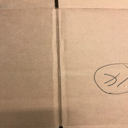

In [23]:
def resize_dataset_image(dataset, size=(128, 128)):
    def resize_image(image):
        return image.resize(size)
    
    for split in dataset:
        dataset[split] = dataset[split].map(lambda x: {"image": resize_image(x["image"]), "label": x["label"]})
    
    return dataset

dataset = resize_dataset_image(dataset)
dataset['train'][0]['image']


In [27]:
def random_flip(image):
    if random.choice([True, False]):
        return image.transpose(Image.FLIP_LEFT_RIGHT)
    else:
        return image.transpose(Image.FLIP_TOP_BOTTOM)

def random_rotate(image, max_angle=30):
    angle = random.uniform(-max_angle, max_angle)
    return image.rotate(angle)

def random_brightness_contrast(image, brightness_factor=1.5, contrast_factor=1.5):
    enhancer = ImageEnhance.Brightness(image)
    image = enhancer.enhance(random.uniform(1, brightness_factor))
    
    enhancer = ImageEnhance.Contrast(image)
    return enhancer.enhance(random.uniform(1, contrast_factor))

def random_crop(image, crop_size=(128, 128)):
    width, height = image.size
    crop_width, crop_height = crop_size
    
    left = random.randint(0, width - crop_width)
    upper = random.randint(0, height - crop_height)
    
    right = left + crop_width
    lower = upper + crop_height
    
    return image.crop((left, upper, right, lower))

def augment_image(sample):
    image = sample['image']
    image = random_flip(image)
    image = random_rotate(image)
    image = random_brightness_contrast(image)
    image = random_crop(image)

    sample['image'] = image
    return sample

augmented_dataset = dataset.map(augment_image)

Map:   0%|          | 0/5054 [00:00<?, ? examples/s]

In [ ]:
class TrashnetDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        # Fetch the image and label
        image = self.dataset[idx]['image']
        label = self.dataset[idx]['label']

        # Apply transformations (augmentation) on-the-fly
        if self.transform:
            image = self.transform(image)

        # Convert image to numpy array for model input
        image = np.array(image) / 255.0  # Normalize to [0, 1]
        image = image.transpose((2, 0, 1))  # Change to CxHxW format (for PyTorch)
        
        # Convert numpy array to tensor
        image = torch.tensor(image, dtype=torch.float32)

        return image, label